# Logistic Regression

### 1 &ensp; Setup

First, we will import some important packages in order to analyze the data throughout the exercise.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

c:\Users\OmriG\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 2 &ensp; Implementation

We first implemented our sigmoid function

In [2]:
def sigmoid(z):
        return 1 / (1 + np.exp(-z))

Before we applied the Logistic Regression, we had implemented it ourselves.\
Our class contains the essential methods including 'fit', 'predict', 'predict_proba', and 'score'.

In [3]:
class LogisticRegression:

    def fit(self, X, y, lr=1e-1, epochs=10):
        
        # Initialize random weights
        self.weights = np.random.standard_normal(X.shape[1])

        # Start training our model
        print(f"\n#################")
        print(f"# Start Training")
        for e in range(1, epochs + 1):
            print(f"## epoch {e} ")
            
            # Calculate gradient
            gradient = np.zeros_like(self.weights)
            for xi, yi in zip(X, y):
                gradient += sigmoid(-yi * self.weights @ xi) * (-yi) * xi
            
            # Update weights
            self.weights -= lr * gradient

            print(f"### train score: {self.score(X, y)}")
        print(f"# Finish Training")
        print(f"#################\n")

        return self

    def predict_proba(self, X):
        # Use sigmoid to estimate the probability of X being labeled as positive
        return sigmoid(X @ self.weights)

    def predict(self, X, threshold=0.5):
        # Predict the labels according to the threshold
        return 2 * (self.predict_proba(X) >= threshold) - 1

    def score(self, X, y):
        # Calculating the accuracy score of our predictions
        return (self.predict(X) == y).sum() / len(y)

### 3 &ensp; Ham-Spam Dataset

We created our own 'train_test_split' method in order to have a better control over the test size and random state.

In [4]:
# Proxy function to control test size and random state
def my_train_test_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

One last preparation was to create a preprocess function to transpose our data from text to vectors

In [5]:
def preprocess_emails(emails_train, emails_test):
    
    # Fitting the tf-idf vectorizer on our train set
    tfidf = TfidfVectorizer().fit(emails_train)

    # Transforming all the data to tf-idf vectors
    train_embeddings = tfidf.transform(emails_train).toarray()
    test_embeddings = tfidf.transform(emails_test).toarray()

    return train_embeddings, test_embeddings

Finally, we used our Logistic Regression on the spam_ham data that was provided to us.

In [6]:
def estimate_spam_probability():

    # Load the data
    dataset = pd.read_csv('spam_ham_dataset.csv')
    X, y = dataset['text'].copy(), dataset['label_num'].copy()
    y[y == 0] = -1

    # Preprocess the data, split to train & test sets
    X_train, X_test, y_train, y_test = my_train_test_split(X, y)
    X_train, X_test = preprocess_emails(X_train, X_test)

    # Fit our model to the train data
    logreg = LogisticRegression().fit(X_train, y_train, lr=0.3, epochs=10)

    # Print results
    print(f"weights: {logreg.weights}")
    print(f"train score: {logreg.score(X_train, y_train)}")
    print(f"test score: {logreg.score(X_test, y_test)}")

    return logreg, X_train, y_train, X_test, y_test
   

estimator, X_train, y_train, X_test, y_test = estimate_spam_probability()


#################
# Start Training
## epoch 1 
### train score: 0.7560444874274661
## epoch 2 
### train score: 0.8508220502901354
## epoch 3 
### train score: 0.8619439071566731
## epoch 4 
### train score: 0.9383462282398453
## epoch 5 
### train score: 0.9702611218568665
## epoch 6 
### train score: 0.9842843326885881
## epoch 7 
### train score: 0.9900870406189555
## epoch 8 
### train score: 0.9920212765957447
## epoch 9 
### train score: 0.9934719535783365
## epoch 10 
### train score: 0.9944390715667312
# Finish Training
#################

weights: [-3.51226496 -6.8865908   0.79817485 ... -1.04897809  0.98344422
  0.86955599]
train score: 0.9944390715667312
test score: 0.9768115942028985


### 4 &ensp; ROC Curve

At last, we used the ROC curve to determine which threshold is the optimal one

In [7]:
from sklearn.metrics import confusion_matrix

def plot_roc_curve(clf, X, y, title):

    # Determine candidate thresholds
    thresholds = np.linspace(0, 1, 11)
    pts = []

    # Iterating over different thresholds
    for th in thresholds:
        
        # Calculating metrics
        y_pred = clf.predict(X, th)
        E = confusion_matrix(y, y_pred)

        pts.append((E[0,1]/(E[0,1]+E[0,0]), E[1,1]/(E[1,0]+E[1,1])))

    # ROC curve        
    xx, yy = zip(*pts)
    plt.scatter(xx, yy, s=20, color = 'black')
    plt.plot(xx, yy, c='red')
        
    # Reference line
    x = np.linspace(0,1,20)
    plt.plot(x, x, color='green', linestyle=':')

    # Labels
    plt.title(title)
    plt.yticks([0,1],['0','1'])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')


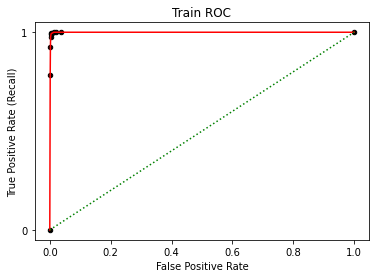

In [8]:
plot_roc_curve(estimator, X_train, y_train, "Train ROC")

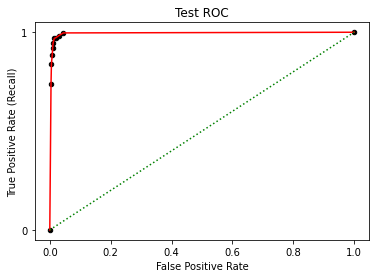

In [9]:
plot_roc_curve(estimator, X_test, y_test, "Test ROC")

As we can see, the best threshold is somewhere between `0.2` and `0.4`, where `0` represents the right-upper point, and `1` represents the lower-left point.